<a href="https://colab.research.google.com/github/hanziyun2/Ziyun-Han-AI-project-submission/blob/main/Ziyun_Han_AI_submittion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd #Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Downloads/test(in).csv') # Load CSV, standardize column names, convert date, and remove rows with invalid dates
df.info()
df.head()
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [17]:
def get_sentiment(text): # Use TextBlob to classify message polarity
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment'] = df['body'].apply(get_sentiment)# Apply sentiment classification

In [18]:
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))# Calculate word count per message and extract month
df['month'] = df['date'].dt.to_period('M').astype(str)

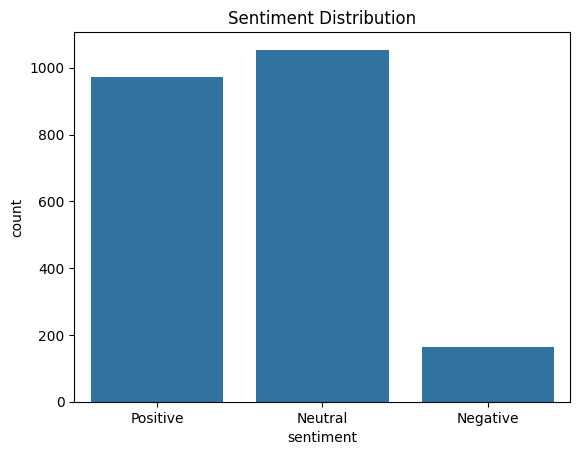

In [19]:
sns.countplot(data=df, x='sentiment')# Plot: Sentiment distribution
plt.title("Sentiment Distribution")
plt.show()

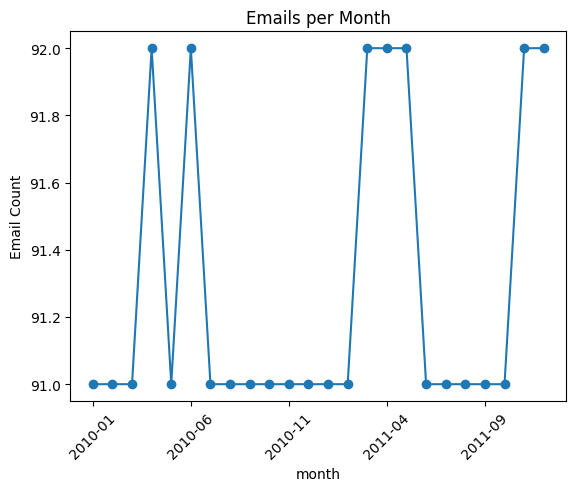

In [20]:
df.groupby('month').size().plot(kind='line', marker='o', title="Emails per Month")# Plot: Monthly email counts
plt.xticks(rotation=45)
plt.ylabel("Email Count")
plt.show()

In [21]:
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}# Map sentiment to scores and aggregate per employee per month
df['score'] = df['sentiment'].map(score_map)
monthly_scores = df.groupby(['from', 'month'])['score'].sum().reset_index()
monthly_scores.to_csv("monthly_scores.csv", index=False)

In [22]:
def rank_employees(month):# Function to return top 3 positive and negative employees for a given month
    scores = monthly_scores[monthly_scores['month'] == month]
    top_positive = scores.sort_values(['score', 'from'], ascending=[False, True]).head(3)
    top_negative = scores.sort_values(['score', 'from'], ascending=[True, True]).head(3)
    return top_positive, top_negative

In [23]:
example_month = monthly_scores['month'].iloc[0]
top_pos, top_neg = rank_employees(example_month)
print("Top 3 Positive Employees:\n", top_pos)
print("Top 3 Negative Employees:\n", top_neg)

Top 3 Positive Employees:
                          from    month  score
120   kayne.coulter@enron.com  2010-01      5
168  patti.thompson@enron.com  2010-01      5
24     don.baughman@enron.com  2010-01      4
Top 3 Negative Employees:
                             from    month  score
192      rhonda.denton@enron.com  2010-01      0
96       johnny.palmer@enron.com  2010-01      1
0    bobette.riner@ipgdirect.com  2010-01      2


In [24]:
risk_employees = []# Check for employees with >= 4 negative messages in any 30-day
neg_msgs = df[df['sentiment'] == 'Negative']

In [25]:
for emp in neg_msgs['from'].unique():
    emp_dates = pd.Series(sorted(neg_msgs[neg_msgs['from'] == emp]['date']))
    for i in range(len(emp_dates)):
        start = emp_dates.iloc[i]
        end = start + pd.Timedelta(days=30)
        count = ((emp_dates >= start) & (emp_dates <= end)).sum()
        if count >= 4:
            risk_employees.append(emp)
            break

In [27]:
flight_risks = pd.DataFrame({'employee': list(set(risk_employees))})# Save results to CSV
flight_risks.to_csv('flight_risks.csv', index=False)
print(flight_risks)

                      employee
0     patti.thompson@enron.com
1      rhonda.denton@enron.com
2      johnny.palmer@enron.com
3      lydia.delgado@enron.com
4  bobette.riner@ipgdirect.com
5         sally.beck@enron.com
6        john.arnold@enron.com


In [28]:
# Build features per employee/month and train linear regression model
features = df.groupby(['from', 'month']).agg(
    email_count=('body', 'count'),
    avg_word_count=('word_count', 'mean'),
    sentiment_score=('score', 'sum')
).reset_index()

In [29]:
X = features[['email_count', 'avg_word_count']]
y = features['sentiment_score']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:
print("R² Score:", r2_score(y_test, y_pred))# Evaluate model
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.4338559986640088
MSE: 3.935487120398106


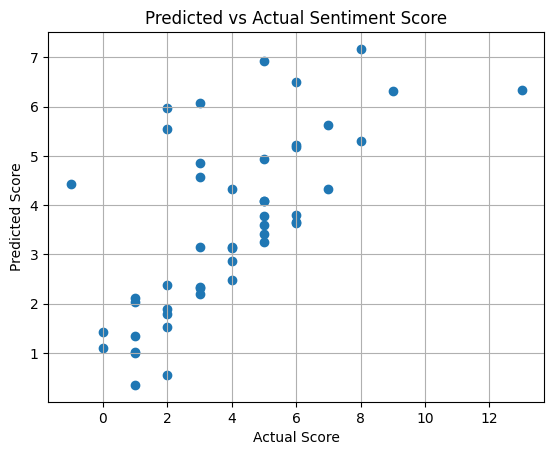

In [33]:
plt.scatter(y_test, y_pred)# Plot: Actual vs Predicted
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Sentiment Score")
plt.grid(True)
plt.show()

In [34]:
df.to_csv("labeled_data.csv", index=False)# Save final labeled and feature datasets
features.to_csv("model_features.csv", index=False)